In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetupProvinces
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle, scipy
import tqdm

mpl.rc('text', usetex=True)
mpl.rc('font', size=8)
mpl.rc('legend', fontsize=7)

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future-mobintime'
n_int_steps = 100
ocp = None
nc = 1

nnodes = 107  # nodes
ndays = 90

setup = ItalySetupProvinces(nnodes, ndays, when)
M = setup.nnodes
N = setup.ndays - 1

outdir = 'model_output/'
file_prefix = 'int-compare'

Loaded Italy Provincial Setup with 107 nodes.


## Help build the scenarios by iterating over posterior realization and beta modifiers (and also compare with matlab)

In [2]:
scn_id = 1
setup = ItalySetupProvinces(nnodes, ndays, when)
M = setup.nnodes
N = setup.ndays - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    #p.prune_mobility(setup, mob_prun=0.0)


scenario = pick_scenario(setup, scn_id)
prefix = file_prefix + '-' + scenario['name']

print(f"""Running scenario {scn_id}: {scenario['name']}, building setup with
ndays: {ndays}
nnodes: {nnodes}
when?  {when}
rk_steps: {n_int_steps}
---> Saving results to prefix: {prefix}""")

p.apply_epicourse(setup, scenario['beta_mult'])

control_initial = np.zeros((M, N))

Loaded Italy Provincial Setup with 107 nodes.
Running scenario 1: L-r3-t479700-id1, building setup with
ndays: 90
nnodes: 107
when?  future-mobintime
rk_steps: 100
---> Saving results to prefix: int-compare-L-r3-t479700-id1


In [3]:
p.apply_epicourse(setup, scenario['beta_mult'])
control_initial = np.zeros((M, N))
results, state_initial, yell, = COVIDVaccinationOCP.accurate_integrate(N,
                                                                  setup=setup,
                                                                  parameters=p,
                                                                  controls=control_initial,
                                                                  save_to=f'{outdir}{prefix}-int-{nnodes}_{ndays}-nc')
exp_accurate_py = results[results['comp']=='yell'].pivot(values = 'value', columns = 'place', index = 'date')

  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/int-compare-L-r3-t479700-id1-int-107_90-nc. Not pruned mob and not the same dim as usual.


100%|██████████| 89/89 [00:00<00:00, 145.59it/s]


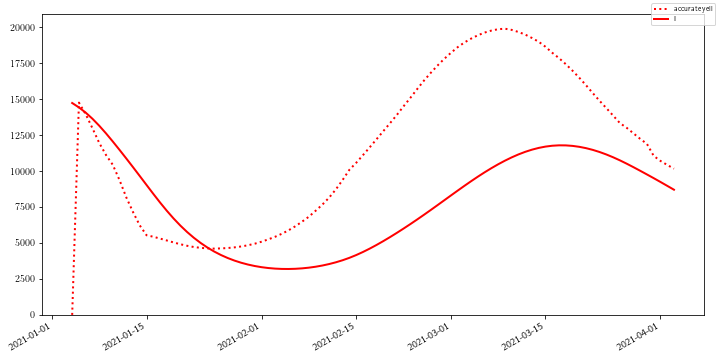

In [4]:
fig, ax = plt.subplots(1,1, figsize = (10,5), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns


ax.plot(exp_accurate_py.sum(axis=1), 
        linestyle=':', lw = 2, label = f'accurate yell', c='r')   #,c = colors[postdraw])

exp_accurate_py_S = results[results['comp']=='S'].pivot(values = 'value', columns = 'place', index = 'date')
exp_accurate_py_I = results[results['comp']=='I'].pivot(values = 'value', columns = 'place', index = 'date')
#ax.plot(exp_accurate_py_S.sum(axis=1), linestyle='-', lw = 2, label = f'S', c='b')
ax.plot(exp_accurate_py_I.sum(axis=1), linestyle='-', lw = 2, label = f'I', c='r')
ax.set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()
fig.legend()

In [5]:
#p.apply_epicourse(setup, scenario['beta_mult'])
#control_initial = np.zeros((M, N))
#p.prune_mobility(setup, 0)
#results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
#                                                                  setup=setup,
#                                                                  parameters=p,
#                                                                  controls=control_initial,
#                                                                  save_to=f'{outdir}{prefix}-int-{nnodes}_{ndays}-nc',
#                                                                  method='rk4',
#                                                                  n_rk4_steps=n_int_steps)
#exp_python = results[results['comp']=='yell'].pivot(values = 'value', columns = 'place', index = 'date')

In [6]:
p.apply_epicourse(setup, scenario['beta_mult'])
control_initial = np.zeros((M, N))
p.prune_mobility(setup, 0)
results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                  setup=setup,
                                                                  parameters=p,
                                                                  controls=control_initial,
                                                                  save_to=f'{outdir}{prefix}-int-{nnodes}_{ndays}-nc',
                                                                  method='rk4',
                                                                  n_rk4_steps=1)
exp_python_alt = results[results['comp']=='yell'].pivot(values = 'value', columns = 'place', index = 'date')

  6%|▌         | 5/89 [00:00<00:01, 49.26it/s]

nnz before: 4088, after: 4088
===> Integrating for model_output/int-compare-L-r3-t479700-id1-int-107_90-nc


100%|██████████| 89/89 [00:01<00:00, 53.31it/s]


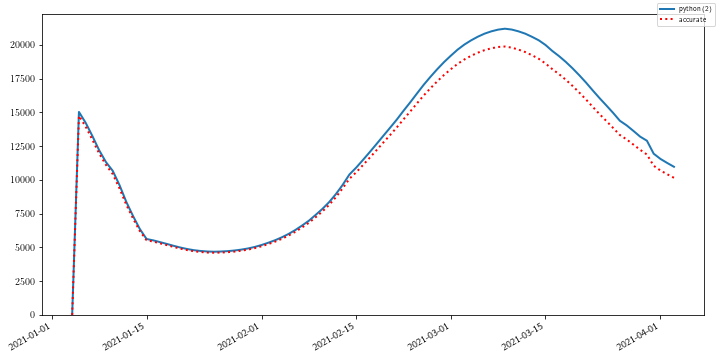

In [7]:
fig, ax = plt.subplots(1,1, figsize = (10,5), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns

ax.plot(exp_python_alt.sum(axis=1), 
        linestyle='-', lw = 2, label = f'python (2)')  #,c = colors[postdraw])
ax.plot(exp_accurate_py.sum(axis=1), 
        linestyle=':', lw = 2, label = f'accurate', c='r')   #,c = colors[postdraw])

ax.set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()
fig.legend()

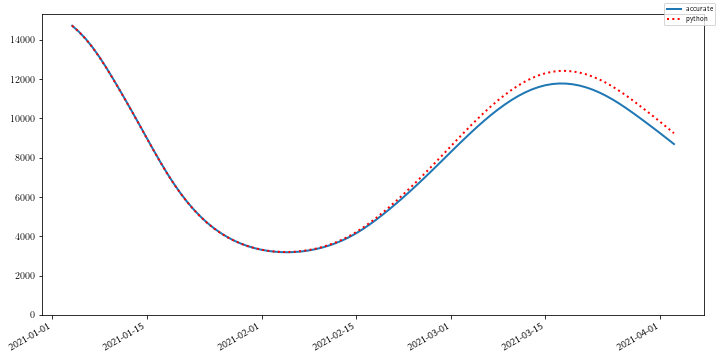

In [8]:
fig, ax = plt.subplots(1,1, figsize = (10,5), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns

ax.plot(exp_accurate_py_I.sum(axis=1), 
        linestyle='-', lw = 2, label = f'accurate')  #,c = colors[postdraw])
ax.plot(results[results['comp']=='I'].pivot(values = 'value', columns = 'place', index = 'date').sum(axis=1), 
        linestyle=':', lw = 2, label = f'python', c='r')   #,c = colors[postdraw])

ax.set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()
fig.legend()

In [9]:
import matlab.engine

eng = matlab.engine.start_matlab()
eng.cd('matlab/post-reviews-update/check-strats-ages/', nargout=0)

eng.workspace['timesV'] = matlab.double(np.arange(738160, 738160+ndays).tolist()) # THIS IS FOR JANUARY 4th

In [10]:
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)

p.apply_epicourse(setup, scenario['beta_mult'])

dosesV = np.zeros((ndays, nnodes))

eng.workspace['Vdoses'] = matlab.double(dosesV.tolist())
eng.workspace['beta_ratio'] = matlab.double(scenario['beta_mult'][0].tolist())
eng.run('main_script_102.m', nargout=0)
ens_exposed = np.array(eng.eval('ens_exposed_preprocess')).flatten()

In [11]:
exp_matlab = np.array(eng.eval('ens_exposed')).squeeze()
skeleton_df = results[results['comp']=='I'].pivot(values = 'value', columns = 'place', index = 'date').copy()
exp_matlab_df = pd.DataFrame(exp_matlab.T, index = skeleton_df.index[1:], columns=skeleton_df.columns)
# ^size is a bit different

In [12]:
int(3.9)

3

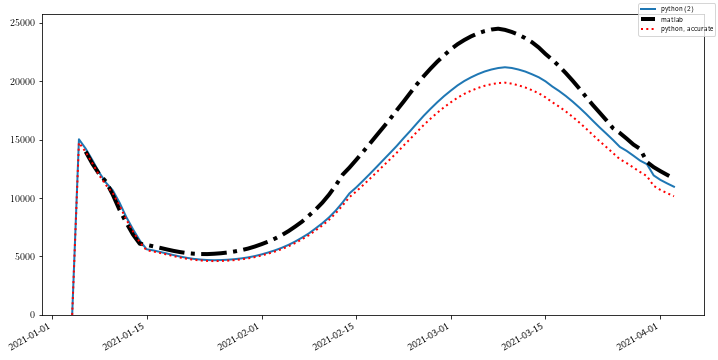

In [13]:
fig, ax = plt.subplots(1,1, figsize = (10,5), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns

#ax.plot(exp_python.sum(axis=1), 
#        linestyle='-', lw = 3, label = f'python')  #,c = colors[postdraw])
ax.plot(exp_python_alt.sum(axis=1), 
        linestyle='-', lw = 2, label = f'python (2)')  #,c = colors[postdraw])
ax.plot(exp_matlab_df.sum(axis=1).diff(), 
        linestyle='-.', lw = 4, label = f'matlab', c='k')   #,c = colors[postdraw])
ax.plot(exp_accurate_py.sum(axis=1), 
        linestyle=':', lw = 2, label = f'python, accurate', c='r')   #,c = colors[postdraw])

ax.set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()
fig.legend()

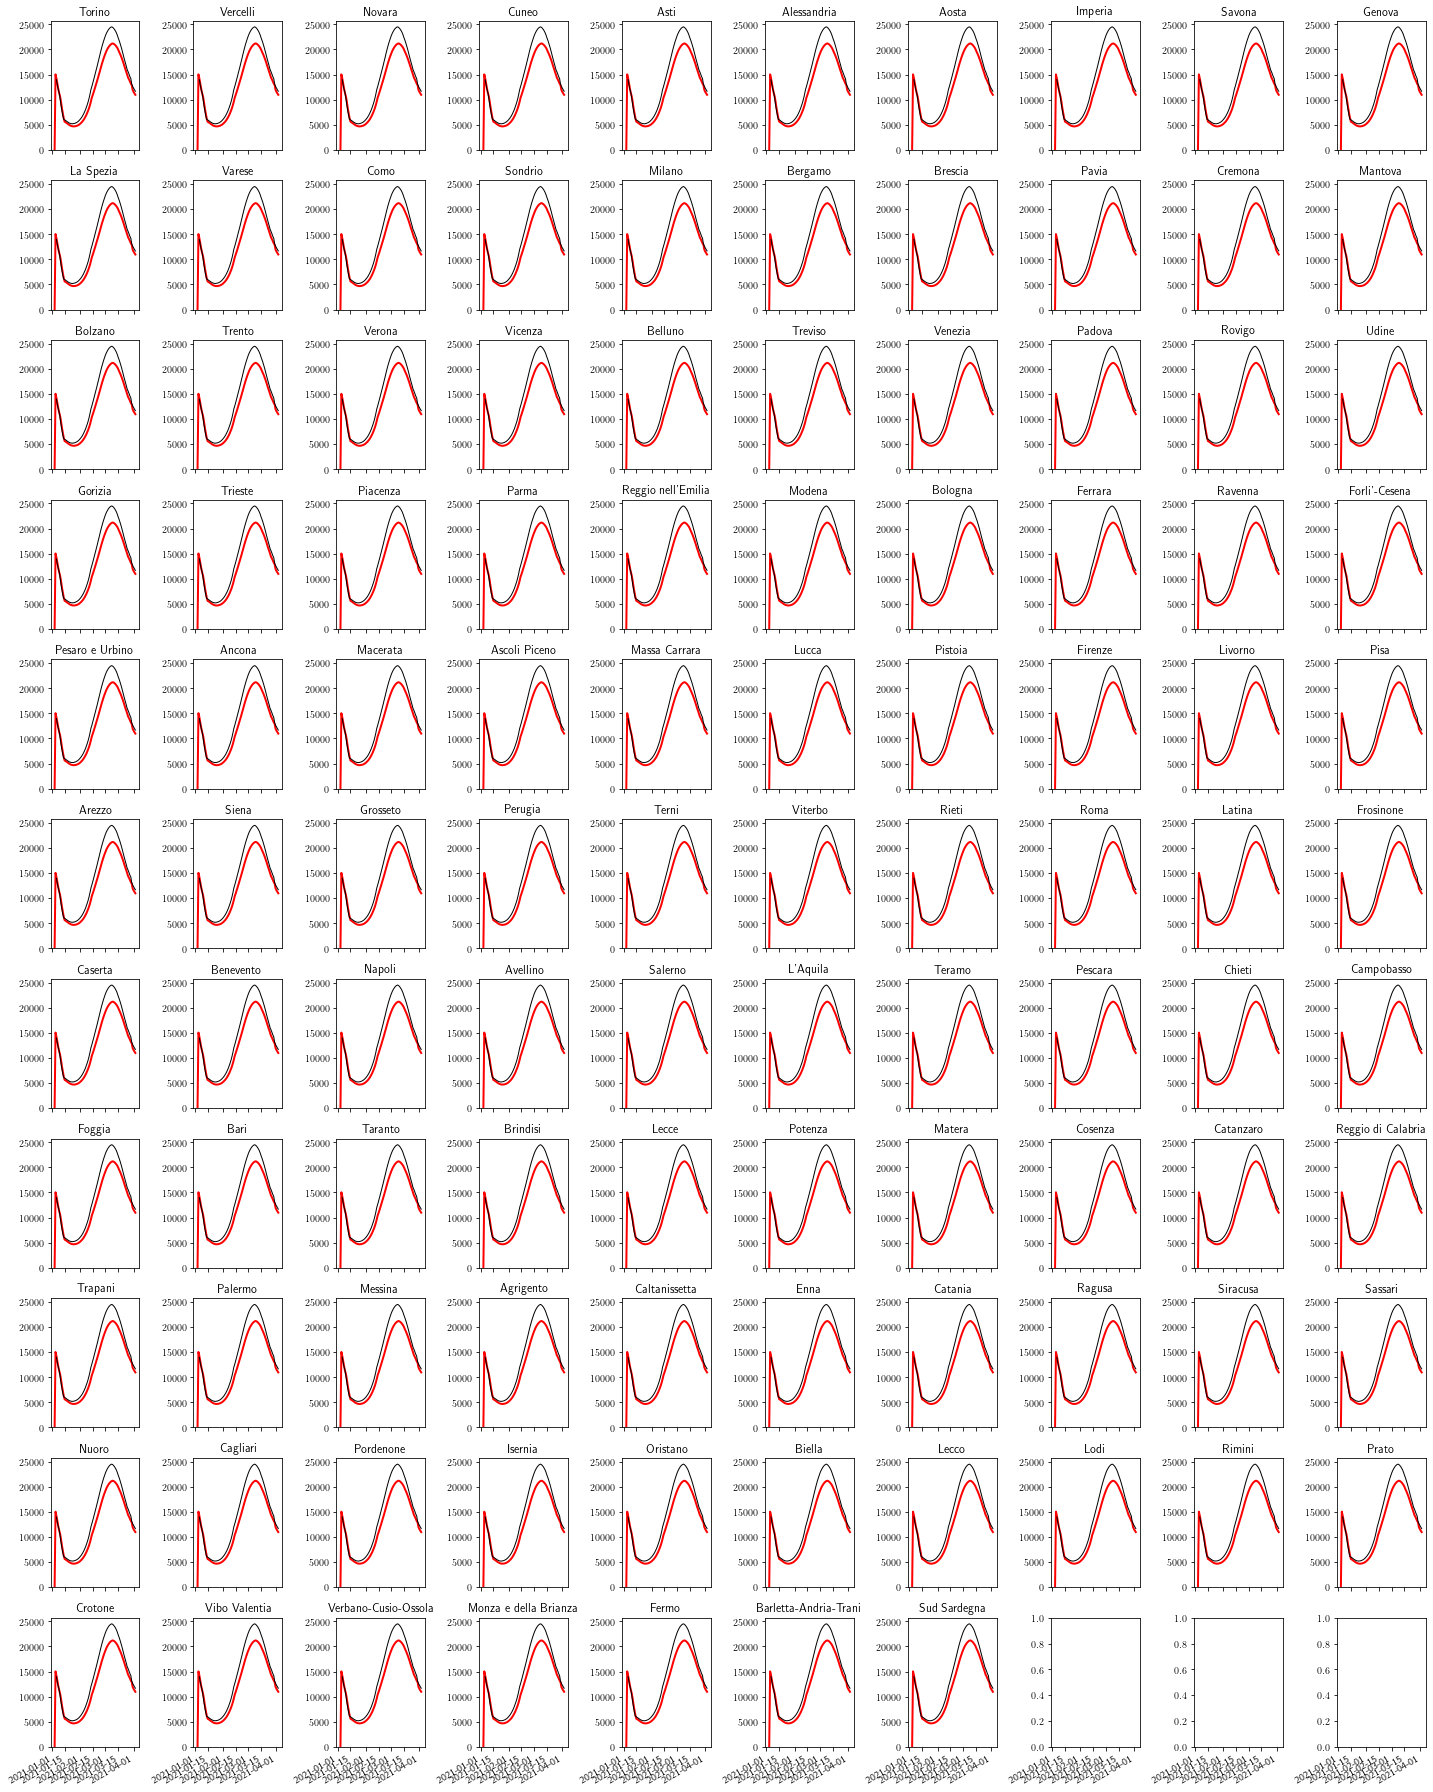

In [14]:
fig, axes = plt.subplots(11,10, figsize = (20,25), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns
for k, nname in enumerate(setup.ind2name):
    #axes.flat[k].plot(exp_python.sum(axis=1), linestyle='-', lw = 2)#, c = colors[postdraw])
    axes.flat[k].plot(exp_python_alt.sum(axis=1), linestyle='-', lw = 2, color='red')#, c = colors[postdraw])
    axes.flat[k].plot(exp_matlab_df.sum(axis=1).diff(), linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    axes.flat[k].set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()